<a href="https://colab.research.google.com/github/ngcheeyuan/Fraud_Detection_Capstone/blob/main/Capstone_Final_Model_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U scikit-learn
!pip install -U imbalanced-learn
!pip install plot_metric
!pip install category_encoders

     |████████████████████████████████| 82 kB 329 kB/s 


In [2]:
#preprocessing, pipelining
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import make_column_transformer , make_column_selector
from sklearn.metrics import balanced_accuracy_score, recall_score,precision_score,make_scorer,matthews_corrcoef

#feature selection tools
from sklearn.feature_selection import VarianceThreshold

#Data Imbalance tools
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

#utility
import pandas as pd
import numpy as np
import pickle

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from xgboost import XGBClassifier

#model selection
from sklearn.model_selection import  GridSearchCV

#plotting
from plot_metric.functions import BinaryClassification
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_tree
from xgboost import to_graphviz
from xgboost import plot_importance
from sklearn import set_config

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
set_config(display="diagram")

### Setting up training and validation 

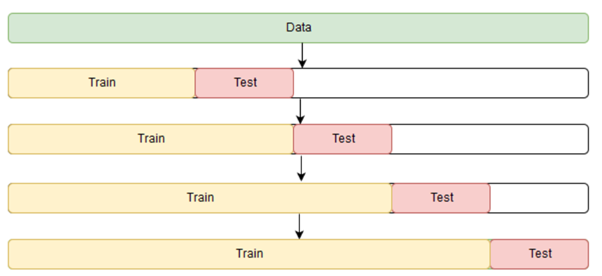

In [4]:
#Custom training/validation split
def rolling_forecast_origin(X_train): #creating a generator function to produce a rolling forecast window, increasing training data by 1 months and validating on 1 months after.
  for month in range(1,13):
    if month > 1:
      X_split_train = X_train.loc['2012-1':f'2014-{month-1}']
      X_split_val = X_train.loc[f'2014-{month}']
    
    else:
      X_split_train = X_train.loc['2012-1':'2013-12']
      X_split_val = X_train.loc['2014-01']

    yield X_split_train,X_split_val

In [82]:
def rolling_forecast_test(X_train,X_test,y_train,y_test): #creating a generator function to produce a rolling forecast window, increasing training data by 1 months and test on 1 months after.
  for month in range(1,13):
    if month > 1:
      X_split_train = X_test.loc['2015-1':f'2015-{month-1}']
      X_split_train = pd.concat([X_train,X_split_train], axis = 0)
      X_split_test = X_test.loc[f'2015-{month}']

      y_split_train = y_test.loc['2015-1':f'2015-{month-1}']
      y_split_train = pd.concat([y_train,y_split_train], axis = 0)
      y_split_test = y_test.loc[f'2015-{month}']
    
    else:
      X_split_train = X_train
      X_split_test = X_test.loc['2015-01']

      y_split_train = y_train
      y_split_test = y_test.loc['2015-01']



    yield X_split_train,X_split_test,y_split_train,y_split_test

In [67]:
def rolling_test(model,cv,model_name):

  #scoring_df = pd.DataFrame(columns = ['model','train_acc','test_acc','train_prec','test_prec','train_rec','test_rec','train_mcc','test_mcc'])
  
  scoring_list = []

  for month,X_split_train,X_split_test,y_split_train,y_split_test in enumerate(cv,1):
    train_preds = model.predict(X_split_train)
    test_preds = model.predict(X_split_test)

    train_acc,train_prec,train_rec,train_mcc,test_acc,test_prec,test_rec,test_mcc = scoring_generator(y_split_train,y_split_test,train_preds,test_preds)


    new_row ={'model':model_name,'month':month,
              'train_acc':train_acc,'train_prec':train_prec,'train_rec':train_rec,'train_mcc':train_mcc,  #train metric
              'test_acc':test_acc,'test_prec':train_prec,'test_rec':train_rec,'test_mcc':test_mcc  #test metric
            }
    
    scoring_list.append(new_row)
   

    #display(scording_df.append(new_row,ignore_index = True))

  return pd.DataFrame(scoring_list)

In [37]:
def scoring_generator(y_tr,y_t,train_preds,test_preds):
    train_acc = balanced_accuracy_score(y_tr,train_preds) #train metrics
    train_prec = precision_score(y_tr,train_preds)
    train_rec = recall_score(y_tr,train_preds)
    train_mcc = matthews_corrcoef(y_tr,train_preds)

    test_acc = balanced_accuracy_score(y_t,test_preds) #test metrics
    test_prec = precision_score(y_t,test_preds)
    test_rec = recall_score(y_t,test_preds)
    test_mcc = matthews_corrcoef(y_t,test_preds)

    return train_acc,train_prec,train_rec,train_mcc,test_acc,test_prec,test_rec,test_mcc

In [12]:
def cv_generator(cv):

  cv_list = []

  for x_train,x_val in cv:
    z_train = x_train.reset_index() # gridsearchCV does not accept dates as index, resetting to remove dates as index
   
    adjustments = z_train.index[-1] 

    z_val = x_val.reset_index()
    z_val.index += adjustments + 2 #s reset_index() will make index start from 0, the value of the last of row + 2 is added to the index value as adjustments.

    cv_list.append((z_train.index,z_val.index[:-1]))
  
  return cv_list

In [29]:
scoring_df = pd.DataFrame(columns = ['model','train_acc','test_acc','train_prec','test_prec','train_rec','test_rec','train_mcc','test_mcc'])


def print_results(model,X_tr,X_t,y_tr,y_t,model_name):
    train_preds = model.predict(X_tr)
    test_preds = model.predict(X_t)

    train_acc,train_prec,train_rec,train_mcc,test_acc,test_prec,test_rec,test_mcc = scoring_generator(y_tr,y_t,train_preds,test_preds)

    new_row ={'model':model_name,
              'train_acc':train_acc,'train_prec':train_prec,'train_rec':train_rec,'train_mcc':train_mcc,  #train metric
              'test_acc':test_acc,'test_prec':train_prec,'test_rec':train_rec, 'test_mcc':test_mcc #test metric
              }

    print(f'train - balanced acc : {train_acc} , precision : {train_prec} , recall: {train_rec}, mcc: {train_mcc}')
    print(f'test - balanced acc : {test_acc} , precision : {test_prec} , recall: {test_rec}, mcc: {test_mcc}')

    return new_row

In [9]:
def evaluation_plot(model,X_tr,X_t,y_tr,y_t,model_name):

  train_preds = model.predict(X_tr)
  test_preds = model.predict(X_t)

  train_proba= model.predict_proba(X_tr)
  test_proba = model.predict_proba(X_t)

  new_row = print_results(model,X_tr,X_t,y_tr,y_t,model_name)

  plt.figure(figsize=(24,12))
  bc = BinaryClassification(y_tr, train_proba[::,1], labels=["Not Fraud", "Fraud"])
  bc1 = BinaryClassification(y_t, test_proba[::,1], labels=["Not Fraud", "Fraud"])

  #plotting ROC-AUC curve
  plt.subplot2grid(shape=(3,12), loc=(0,0), colspan=3)
  bc.plot_roc_curve(title = 'Training - ROC')
  plt.subplot2grid(shape=(3,12), loc=(0,3), colspan=3)
  bc1.plot_roc_curve(title  = 'Testing - ROC')
  
  #plotting Precission-recall curve
  plt.subplot2grid((3,12), (1,0), colspan=3)
  bc.plot_precision_recall_curve(title = 'Training - Precision -Recall Curve')
  plt.subplot2grid((3,12), (1,3), colspan=3)
  bc1.plot_precision_recall_curve(title = 'Testing - Precision -Recall Curve')

  #plot confusion matrix
  plt.subplot2grid((3,12), (0,6), colspan=3)
  bc.plot_confusion_matrix(title ='Training')
  plt.subplot2grid((3,12), (0,9), colspan=3)
  bc1.plot_confusion_matrix(title = 'Testing')

  
  #plot confusion matrix with the values normalized
  plt.subplot2grid((3,12), (1,6), colspan=3)
  bc.plot_confusion_matrix(title ='Training' , normalize = True)
  plt.subplot2grid((3,12), (1,9), colspan=3)
  bc1.plot_confusion_matrix(title = 'Testing', normalize = True)

  '''
  plt.subplot2grid((3,12), (2,3), colspan=3)
  bc.plot_class_distribution(title ='Training')
  plt.subplot2grid((3,12), (2,6), colspan=3)
  bc1.plot_class_distribution(title = 'Testing')
  '''
  return new_row

In [10]:
def plot_cross_val_results(gs,X_tr,y_tr):
  print(f'best params {gs.best_params_}')


  
  train_preds = gs.predict(X_tr)

  train_acc = balanced_accuracy_score(y_tr,train_preds) #train metrics
  train_prec = precision_score(y_tr,train_preds)
  train_rec = recall_score(y_tr,train_preds)
  train_mcc = matthews_corrcoef(y_tr,train_preds)
  
  scores = pd.DataFrame(gs.cv_results_).filter(items = ['mean_test_balanced_accuracy', 'mean_test_precision','mean_test_recall', 'mean_test_mcc',
                                                        'rank_test_balanced_accuracy','rank_test_precision','rank_test_recall', 'rank_test_mcc'])
  
  mask = scores['rank_test_balanced_accuracy']==1
  val_acc = scores.loc[mask,'mean_test_balanced_accuracy'].values[0]
  val_prec = scores.loc[mask,'mean_test_precision'].values[0]
  val_rec = scores.loc[mask,'mean_test_recall'].values[0]
  val_mcc = scores.loc[mask,'mean_test_mcc'].values[0]
  

  print(f'train           - balanced acc : {train_acc} , precision : {train_prec} , recall: {train_rec}, mcc: {train_mcc}')
  print(f'mean validation - balanced acc : {val_acc} , precision : {val_prec} , recall: {val_rec}, mcc: {val_mcc}')

  fig,ax = plt.subplots(nrows = 2, ncols =2,figsize = (24,12))

  for i,metric in enumerate(['balanced_accuracy','precision','recall','mcc']):

    row = i//2 #when i = 0,1, i//2 == 0 when i = 2, i//2 == 1
    col = i%2  #if i is odd, col == 1, if i is even col = 0 
    
    #plot each scoring metric of each permutation of the parameters of each fold.
    pd.DataFrame(gs.cv_results_).drop(columns = [f'rank_test_{metric}',f'mean_test_{metric}',f'std_test_{metric}'],axis = 'columns')\
                                        .filter(like =f'test_{metric}').T\
                                        .plot(ax = ax[row,col], legend = False).set_title(f'{metric}')
    ax[row,col].set_xticks(range(12))
    ax[row,col].set_xticklabels(range(1,13))
    ax[row,col].set_xlabel('split')

    #ax[row,col].legend(loc='upper right')
    ax[row,col].set_ylim([0, 1])
  return gs.best_score_

In [14]:
def down_cast(df_):
  cat_columns = ['city','state','merchant','job','category','name','cc_num']
  df_[cat_columns] = df_[cat_columns].astype('category')
  unsigned_int = ['is_fraud','trans_year','trans_month','weekday','hour','day','age_at_trans','age_bin','time_risk',
                  'trans_flag_60d_ma','trans_flag_60d_ewm','flag_cat_amt','flag_1','flag_2','flag_3']
  df_[unsigned_int] = df_[unsigned_int].apply(pd.to_numeric, downcast='unsigned')
  fcols = df_.select_dtypes('float').columns
  df_[fcols] = df_[fcols].apply(pd.to_numeric, downcast='float')

  return df_

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Reading in data

In [16]:
df_train = pd.read_csv('/content/drive/MyDrive/Capstone Dataset/train_engineered.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Capstone Dataset/test_engineered.csv')

In [17]:
df_train.fillna(0,inplace = True )
df_test.fillna(0,inplace = True )

In [18]:
df_train['trans_date_time'] = pd.to_datetime(df_train['trans_date_time'])
df_train.sort_values(by = 'trans_date_time', inplace = True)
df_train.set_index('trans_date_time',inplace = True)
df_test['trans_date_time'] = pd.to_datetime(df_test['trans_date_time'])
df_test.sort_values(by = 'trans_date_time', inplace = True)
df_test.set_index('trans_date_time',inplace = True)

In [19]:
df_train = down_cast(df_train)
df_test = down_cast(df_test)

In [20]:
features = ['cc_num','job','category','merchant','amt','trans_month','weekday','time_risk','age_bin','flag_cat_amt',
            'total_amt','amt_lower_bound','amt_upper_bound_2','trans_flag_60d_ewm','ewm_5d_outlier']

In [21]:
X_train = df_train.loc[:,features].copy()
y_train = df_train.loc[:,'is_fraud'].copy()


X_test = df_test.loc[:,features].copy()
y_test= df_test.loc[:,'is_fraud'].copy()

### Setting up Pipeline

In [22]:
ohe = OneHotEncoder()
scaler = MinMaxScaler()
#sm = SMOTENC(random_state=42,sampling_strategy = 0.15, categorical_features=[0,1,2,3]) # not enough ram to run this.
tgt = TargetEncoder(smoothing = 50) #adding a smoothing factor as some of the jobs/cc num has very small samples, adding smoothing factor to reduce overfitting.
var = VarianceThreshold(threshold=(.95 * (1 - .95))) # remove all features that are 95% 0 or 1

ctf = make_column_transformer((scaler,make_column_selector(dtype_include=np.number)), # run mix-max scaler on numerical data type, saga solver requires a scaled dataset.
#                              (ohe,make_column_selector(dtype_include = object)), #One hot encode object daatype
                              (tgt,['job','merchant','cc_num','category']), #base on our EDA there seems to be some jobs, merchants and even credit-cards are more prone to fradulent activites than others.
                              remainder = 'passthrough')

ratio = 0.15
over = RandomOverSampler(sampling_strategy = ratio)
under = RandomUnderSampler(sampling_strategy = 0.65)


weight = 1/ratio


log_model = make_pipeline(ctf,
#                         var,
                          over,
#                         under,  
                          LogisticRegression(class_weight='balanced', 
                                             max_iter = 1000, 
                                             solver = 'saga', 
                                             tol = 0.1,
                                             random_state = 42)) #using class weights to adjust for class imbalance

xgboost_model = make_pipeline(ctf,
                              over, #over sample positive class
#                             under,
                              var,
                              XGBClassifier(tree_method = 'hist',
                                            max_delta_step = 10,
                                            subsample = 0.5,colsample_by_tree = 0.5, 
                                            min_child_weight = 30,gamma = 30,
                                            objective = 'binary:logistic',
                                            random_state = 42
#                                           scale_pos_weight = weight #and provide a weight to adjust for the class imbalance
                                            ))

rf_model = make_pipeline(ctf,
                         over,
                         RandomForestClassifier(class_weight = 'balanced',
                                                random_state = 42))

In [101]:
rolling_cv = rolling_forecast_origin(X_train)
cv = cv_generator(rolling_cv)

pipe_params = {'logisticregression__C':np.linspace(0.01,0.1,5)} #tested 0.01 to 1

scoring = {'balanced_accuracy' : make_scorer(balanced_accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'mcc' : make_scorer(matthews_corrcoef)}


gs = GridSearchCV(log_model, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=cv, # custom folds 
                  scoring = scoring,
                  verbose = False,
                  refit = 'balanced_accuracy') 

In [102]:
gs.fit(X_train,y_train)

GridSearchCV(cv=[(RangeIndex(start=0, stop=923485, step=1),
                  RangeIndex(start=923486, stop=949732, step=1)),
                 (RangeIndex(start=0, stop=949732, step=1),
                  RangeIndex(start=949733, stop=973728, step=1)),
                 (RangeIndex(start=0, stop=973728, step=1),
                  RangeIndex(start=973729, stop=1009239, step=1)),
                 (RangeIndex(start=0, stop=1009239, step=1),
                  RangeIndex(start=1009240, stop=104236...
                                                           max_iter=1000,
                                                           random_state=42,
                                                           solver='saga',
                                                           tol=0.1))]),
             param_grid={'logisticregression__C': array([0.01  , 0.0325, 0.055 , 0.0775, 0.1   ])},
             refit='balanced_accuracy',
             scoring={'balanced_accuracy': make_scorer(balanced_accuracy_score),
                      'mcc': make_scorer(matthews_corrcoef),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=False)

In [103]:
with open('logistic_regression', 'wb') as files:
    pickle.dump(gs, files)

best params {'logisticregression__C': 0.1}
train           - balanced acc : 0.9732589513170323 , precision : 0.1240560208705204 , recall: 0.9650200267022697, mcc: 0.3425341670608623
mean validation - balanced acc : 0.9678606011267373 , precision : 0.14332192447927974 , recall: 0.9519095039153789, mcc: 0.355510644796938


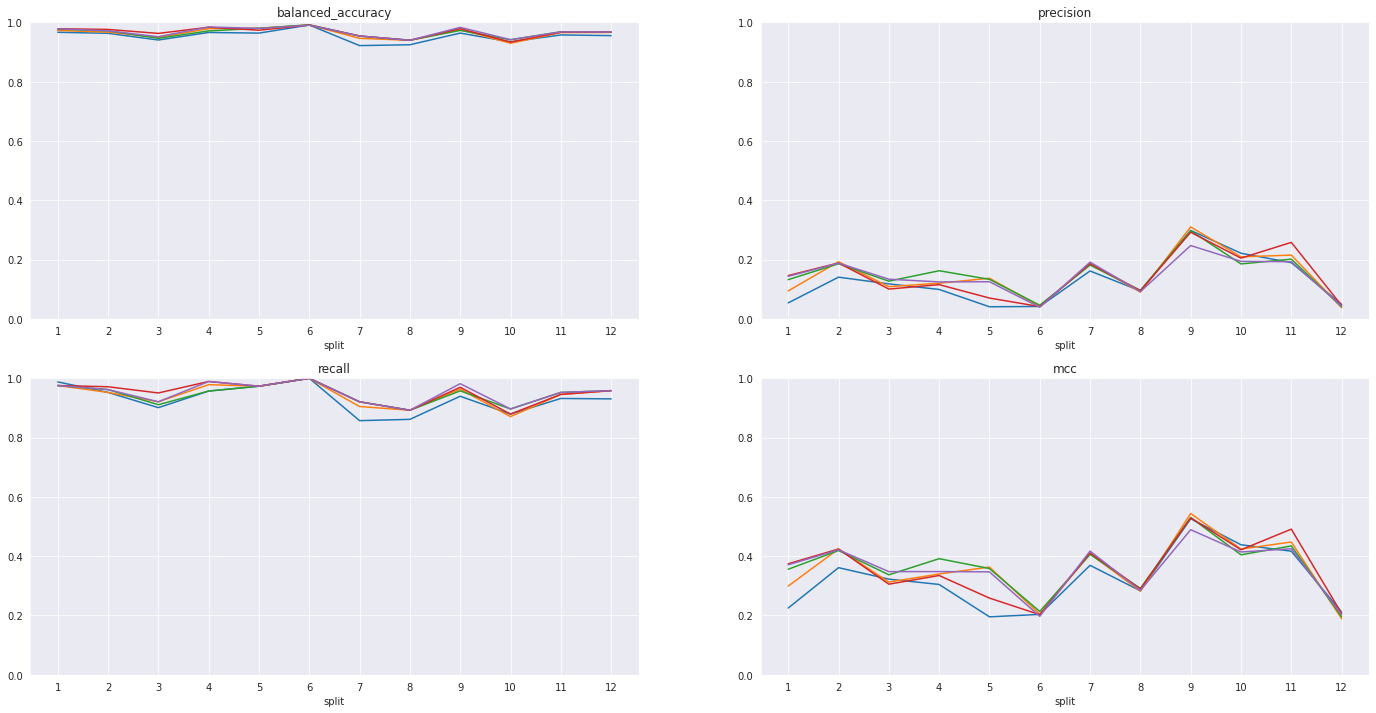

In [104]:
best_score = plot_cross_val_results(gs,X_train,y_train)

In [105]:
cv = rolling_forecast_test(X_train,X_test,y_train,y_test)
log_test_score = rolling_test(gs,cv,'logistic regression')

In [106]:
log_test_score

,model,train_acc,train_prec,train_rec,train_mcc,test_acc,test_prec,test_rec,test_mcc
0,logistic regression,0.973259,0.124056,0.965020,0.342534,0.988076,0.124056,0.965020,0.501531
1,logistic regression,0.973888,0.126964,0.966266,0.346761,0.982279,0.126964,0.966266,0.451234
2,logistic regression,0.974094,0.128308,0.966642,0.348669,0.963882,0.128308,0.966642,0.384045
3,logistic regression,0.973773,0.129083,0.966008,0.349599,0.979522,0.129083,0.966008,0.251245
4,logistic regression,0.973835,0.127780,0.966126,0.347854,0.978814,0.127780,0.966126,0.312348
5,logistic regression,0.973944,0.127042,0.966426,0.346888,0.989306,0.127042,0.966426,0.286816
6,logistic regression,0.974204,0.125868,0.967018,0.345378,0.985118,0.125868,0.967018,0.331698
7,logistic regression,0.974471,0.125522,0.967605,0.345002,0.973230,0.125522,0.967605,0.249032
8,logistic regression,0.974453,0.124074,0.967578,0.343000,0.948428,0.124074,0.967578,0.444731
9,logistic regression,0.973753,0.125418,0.966058,0.344593,0.972712,0.125418,0.966058,0.406011


train - balanced acc : 0.9732589513170323 , precision : 0.1240560208705204 , recall: 0.9650200267022697, mcc: 0.3425341670608623
test - balanced acc : 0.9732661515221595 , precision : 0.12002494024732412 , recall: 0.9657190635451505, mcc: 0.3369240877191632


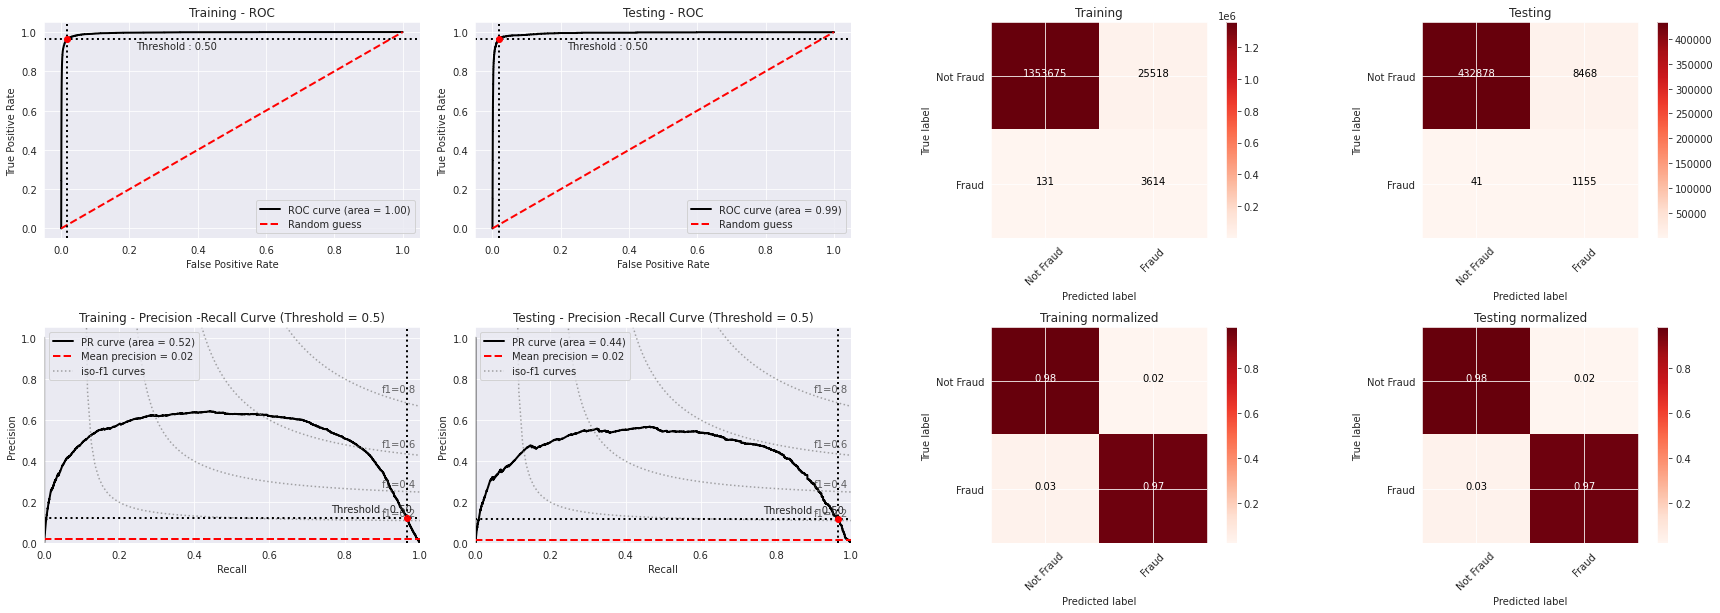

In [108]:
new_row = evaluation_plot(gs,X_train,X_test,y_train,y_test,'Logistic')

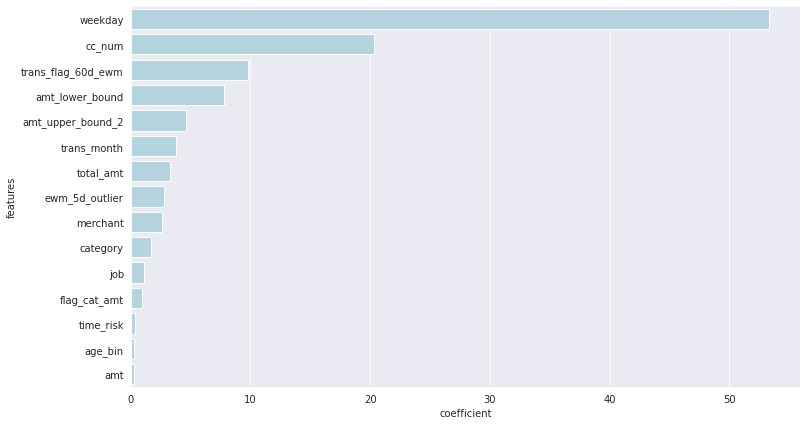

In [107]:
importance = gs.best_estimator_.named_steps["logisticregression"].coef_[0]
feature_importance = pd.DataFrame({'features' :X_train.columns,
                                   'coefficient' : abs(importance)}).sort_values(by='coefficient', ascending = False)
feature_importance['rank'] = feature_importance['coefficient'].rank(ascending = False)                                 
plt.figure(figsize = (12,7))  
sns.barplot( y= feature_importance['features'], x = feature_importance['coefficient'], orient = 'h', color = 'lightblue');

In [90]:
scoring_df = scoring_df.append(new_row,ignore_index = True) #storing scores

In [93]:
rolling_cv = rolling_forecast_origin(X_train)
cv = cv_generator(rolling_cv)

pipe_params = {'variancethreshold__threshold':[(0.95)*(1-0.95),(0.975)*(1-0.975),(0.99)*(1-0.99)],
               'xgbclassifier__max_depth':[6,7],
               'xgbclassifier__gamma':[30],
               'xgbclassifier__min_child_weight':[30]}

scoring = {'balanced_accuracy' : make_scorer(balanced_accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'mcc' : make_scorer(matthews_corrcoef)
          }


gs = GridSearchCV(xgboost_model, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=cv, # custom folds z
                  scoring = scoring,
                  verbose = False,
                  refit = 'balanced_accuracy') 

In [94]:
gs.fit(X_train,y_train)

GridSearchCV(cv=[(RangeIndex(start=0, stop=923485, step=1),
                  RangeIndex(start=923486, stop=949732, step=1)),
                 (RangeIndex(start=0, stop=949732, step=1),
                  RangeIndex(start=949733, stop=973728, step=1)),
                 (RangeIndex(start=0, stop=973728, step=1),
                  RangeIndex(start=973729, stop=1009239, step=1)),
                 (RangeIndex(start=0, stop=1009239, step=1),
                  RangeIndex(start=1009240, stop=104236...
                                                          0.02437500000000002,
                                                          0.00990000000000001],
                         'xgbclassifier__gamma': [30],
                         'xgbclassifier__max_depth': [6, 7],
                         'xgbclassifier__min_child_weight': [30]},
             refit='balanced_accuracy',
             scoring={'balanced_accuracy': make_scorer(balanced_accuracy_score),
                      'mcc': make_scorer(matthews_corrcoef),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=False)

best params {'variancethreshold__threshold': 0.00990000000000001, 'xgbclassifier__gamma': 30, 'xgbclassifier__max_depth': 6, 'xgbclassifier__min_child_weight': 30}
train           - balanced acc : 0.9125181262880051 , precision : 0.2510072522159549 , recall: 0.8317757009345794, mcc: 0.45465463009656776
mean validation - balanced acc : 0.9022802047794886 , precision : 0.23988606406023535 , recall: 0.8121953414658315, mcc: 0.4274093417313714


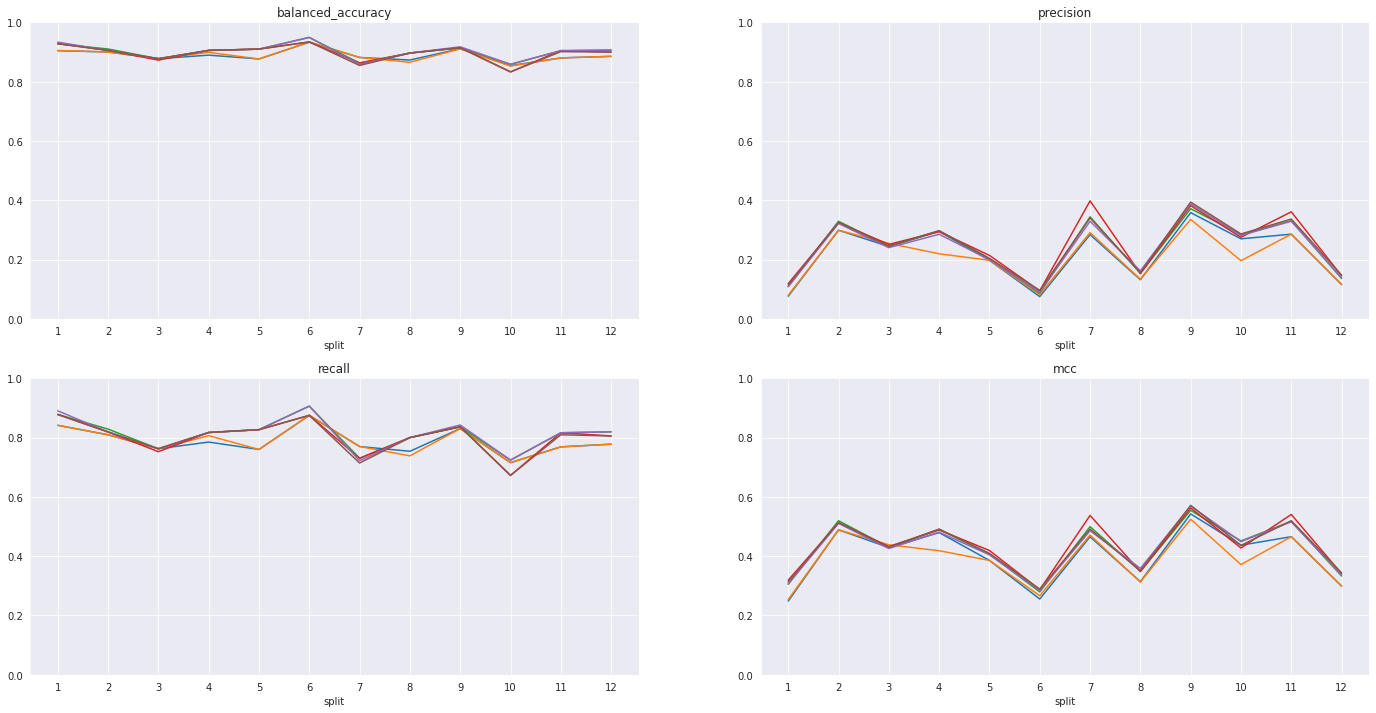

In [95]:
best_score = plot_cross_val_results(gs,X_train,y_train)

In [96]:
cv = rolling_forecast_test(X_train,X_test,y_train,y_test)
xgb_test_score = rolling_test(gs,cv,'xgboost')

In [100]:
xgb_test_score

,model,train_acc,train_prec,train_rec,train_mcc,test_acc,test_prec,test_rec,test_mcc
0,xgboost,0.912518,0.251007,0.831776,0.454655,0.928311,0.251007,0.831776,0.509751
1,xgboost,0.913264,0.252987,0.833376,0.456853,0.942967,0.252987,0.833376,0.534476
2,xgboost,0.914040,0.254515,0.834951,0.458664,0.870070,0.254515,0.834951,0.438996
3,xgboost,0.912655,0.254704,0.832208,0.458056,0.859647,0.254704,0.832208,0.276986
4,xgboost,0.912093,0.251516,0.831107,0.454867,0.902954,0.251516,0.831107,0.395031
5,xgboost,0.911884,0.249877,0.830730,0.453265,0.918496,0.249877,0.830730,0.396208
6,xgboost,0.912000,0.248408,0.830967,0.451995,0.927681,0.248408,0.830967,0.431348
7,xgboost,0.912385,0.247523,0.831769,0.451401,0.892468,0.247523,0.831769,0.304685
8,xgboost,0.912123,0.244280,0.831275,0.448290,0.893210,0.244280,0.831275,0.487375
9,xgboost,0.911631,0.245459,0.830290,0.449099,0.908324,0.245459,0.830290,0.433419


train - balanced acc : 0.9125181262880051 , precision : 0.2510072522159549 , recall: 0.8317757009345794, mcc: 0.45465463009656776
test - balanced acc : 0.9060556175319383 , precision : 0.21484888304862024 , recall: 0.8202341137123745, mcc: 0.4172319868414967


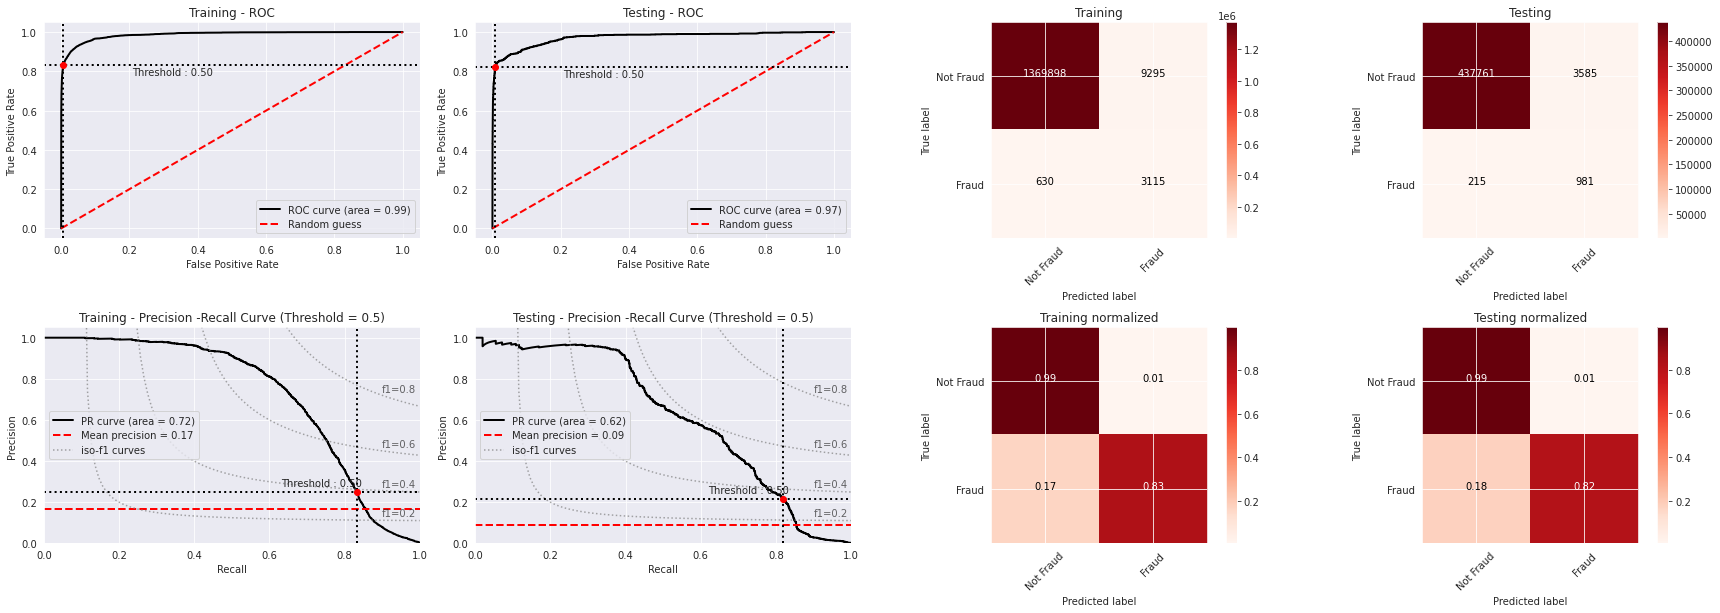

In [97]:
new_row = evaluation_plot(gs,X_train,X_test,y_train,y_test,'xgboost')
scoring_df = scoring_df.append(new_row,ignore_index = True)

In [98]:
feature_list = [(feature,f'f{index}') for index,feature in enumerate(X_train.columns)]
xgboost_features = [feature for feature,index in feature_list if index in gs.best_estimator_.named_steps["xgbclassifier"].get_booster().feature_names]
gs.best_estimator_.named_steps["xgbclassifier"].get_booster().feature_names = xgboost_features

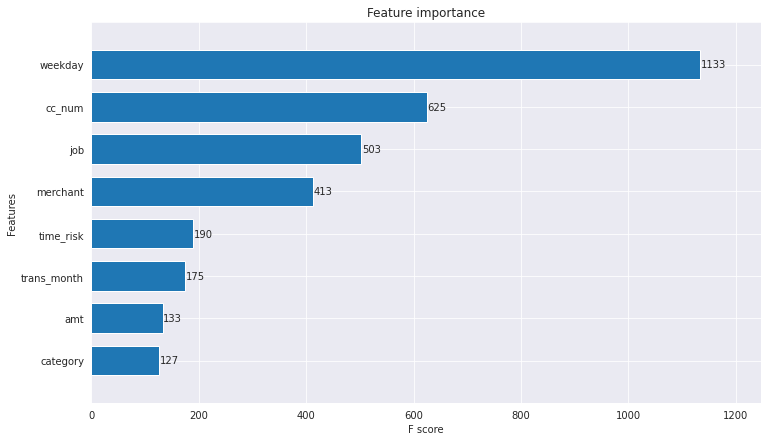

In [99]:
fig,ax = plt.subplots(figsize = (12,7))
plot_importance(gs.best_estimator_.named_steps["xgbclassifier"].get_booster(), height = 0.7,ax = ax)
plt.rc('font', size=10)